# Privacy, Utility & Fairness Analysis
This notebook loads the experimental results in **`results.zip`** and produces the key plots discussed:

1. ε vs **Utility** (DPSGD & SGD)  
2. ε vs **Fairness** (DPSGD & SGD)  
3. ε vs **Fairness** for **AGT** at a fixed query budget  
4. Query budget vs **Fairness** for **AGT** at a fixed ε  
5. Heat-map of (ε, *n* queries) → Fairness for **AGT**  
6. Utility-Fairness scatter with Pareto frontiers  

Feel free to adapt metric names, styling, and add further analyses in the **Extra ideas** section at the end.

In [1]:
import os, json, zipfile
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Increase default figure size
plt.rcParams['figure.figsize'] = (6, 4)

In [2]:
results_dir = Path('../results')

# Ensure it exists
if not results_dir.exists():
    raise FileNotFoundError(f"Results directory {results_dir} does not exist.")

In [15]:
import os
import re
import json
import numpy as np
import pandas as pd

def parse_results(results_dir):
    """
    Walks through results_dir/<dataset>_dataset/*.json,
    parses dataset, technique, epsilon, delta, and n_queries (for AGT),
    and returns a single DataFrame indexed by dataset, epsilon, n_queries.
    Columns include: technique, delta, and for each metric:
    - <metric>         (the mean for SGD/DPSGD, or mean for AGT)
    - std_<metric>     (NaN for SGD/DPSGD, or std for AGT)
    """
    # delta is fixed per dataset for DPSGD/AGT
    delta_map = {
        'adult':    1e-5,
        'acs_income': 1e-6,
    }

    rows = []
    for root, _, files in os.walk(results_dir):
        # skip non-dataset dirs
        if not root.endswith('_dataset'):
            continue

        # infer dataset name
        dataset = os.path.basename(root).replace('_dataset','')

        for fname in files:
            if not fname.endswith('.json') or fname.startswith('._'):
                continue

            path = os.path.join(root, fname)
            with open(path, 'r') as f:
                data = json.load(f)

            # strip “.json”
            base = fname[:-5]

            # rest = part after "<dataset>_"
            assert base.startswith(dataset + '_'), \
                f"unexpected file name {fname}"
            rest = base[len(dataset) + 1:]
            tech = rest.split('_')[0]

            if tech in ('sgd', 'dpsgd'):
                # parse ε and δ
                if tech == 'sgd':
                    eps = np.inf
                    delta = np.nan
                else:
                    m = re.match(r'dpsgd_eps(?P<eps>[\d\.]+)_delta(?P<delta>[\deE\-\+\.]+)', rest)
                    eps   = float(m.group('eps'))
                    delta = float(m.group('delta'))

                # single set of metrics: accuracy, demographic_parity, equalised_odds, etc.
                row = {
                    'dataset':   dataset,
                    'technique': tech,
                    'epsilon':   eps,
                    'delta':     delta,
                    'n_queries': np.nan
                }
                for metric, val in data.items():
                    row[metric]     = val
                    row['std_' + metric] = np.nan

                rows.append(row)

            elif tech == 'agt':
                # AGT file: multiple “<n_queries>_<epsilon>” keys
                delta = delta_map[dataset]
                for idx_key, stats in data.items():
                    n_q_str, eps_str = idx_key.split('_', 1)
                    n_q   = int(n_q_str)
                    eps   = float(eps_str)

                    row = {
                        'dataset':   dataset,
                        'technique': tech,
                        'epsilon':   eps,
                        'delta':     delta,
                        'n_queries': n_q
                    }
                    # each stats[metric] == {'mean':…, 'std':…}
                    for metric, mstats in stats.items():
                        row[metric]       = mstats['mean']
                        row['std_' + metric] = mstats['std']

                    rows.append(row)

            else:
                raise ValueError(f"Unrecognized technique: {tech}")

    # build DataFrame
    df = pd.DataFrame(rows)

    # set a 3‐level index: dataset → ε → n_queries
    df = df.set_index(['dataset','epsilon','n_queries'])
    df = df.sort_index()

    return df

In [18]:
result_df = parse_results(results_dir)

# Fairness Metrics (and utility) for DPSGD and SGD vs Privacy Budgets

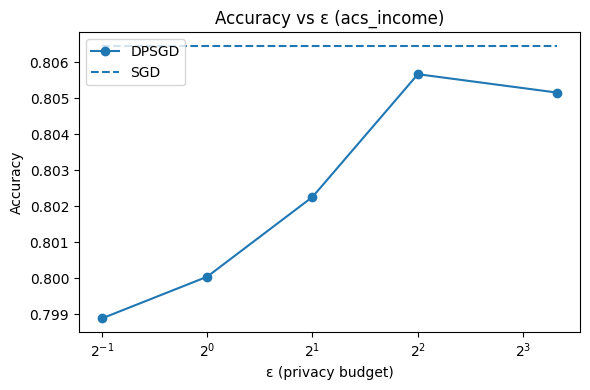

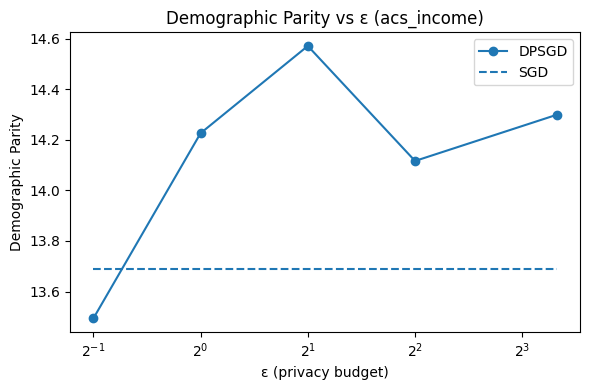

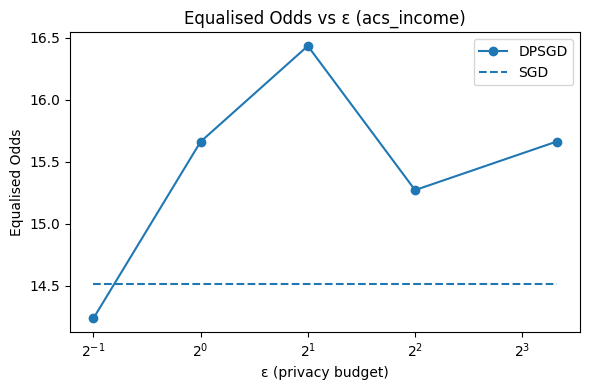

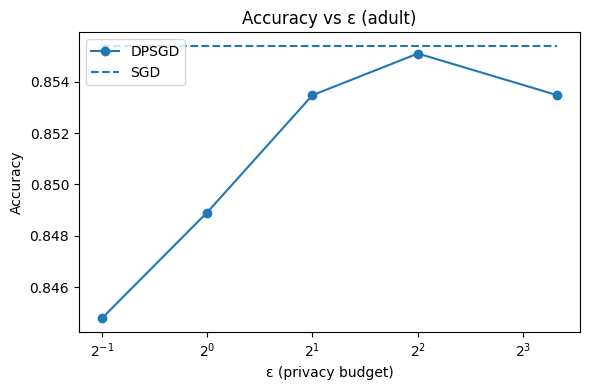

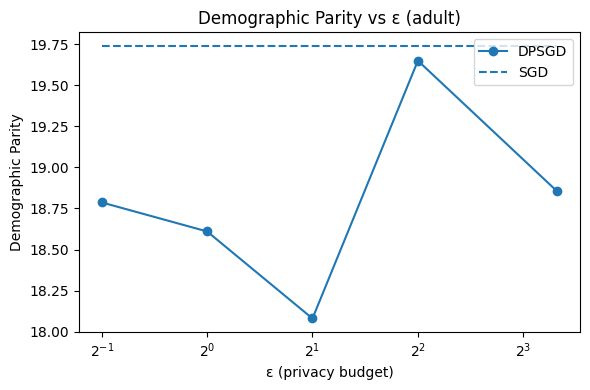

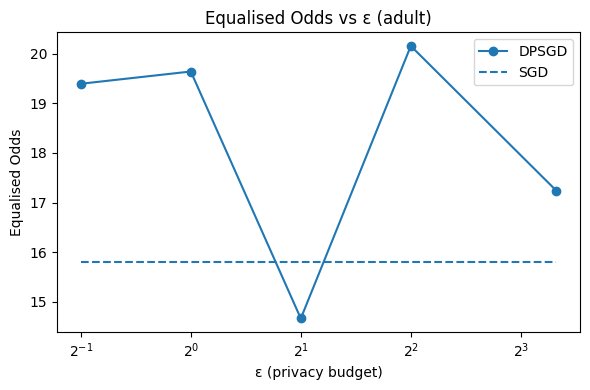

In [19]:
# Flatten the index so we can filter easily
df_flat = result_df.reset_index()

# Keep only the private‐learning mechanisms
df_priv = df_flat[df_flat['technique'].isin(['sgd', 'dpsgd'])].copy()

# Identify which columns are your metrics
all_metrics = [
    c for c in df.columns
    if not c.startswith('std_') and c not in ['technique','delta','n_queries']
]
accuracy_metric = 'accuracy'
fairness_metrics = [m for m in all_metrics if m != accuracy_metric]

# Loop over each dataset
for dataset in df_priv['dataset'].unique():
    sub = df_priv[df_priv['dataset'] == dataset]
    dpsgd = sub[sub['technique'] == 'dpsgd']
    # SGD is a single flat line
    sgd_val = float(sub[sub['technique'] == 'sgd'][accuracy_metric].iloc[0])

    # --- 1) Accuracy vs ε ---
    plt.figure()
    plt.plot(
        dpsgd['epsilon'],
        dpsgd[accuracy_metric],
        marker='o',
        label='DPSGD'
    )
    # flat SGD baseline
    plt.hlines(
        sgd_val,
        xmin=dpsgd['epsilon'].min(),
        xmax=dpsgd['epsilon'].max(),
        linestyle='--',
        label='SGD'
    )
    plt.xscale('log', base=2)
    plt.xlabel('ε (privacy budget)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs ε ({dataset})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 2) Each fairness metric vs ε ---
    for metric in fairness_metrics:
        sgd_met = float(sub[sub['technique'] == 'sgd'][metric].iloc[0])
        plt.figure()
        plt.plot(
            dpsgd['epsilon'],
            dpsgd[metric],
            marker='o',
            label='DPSGD'
        )
        plt.hlines(
            sgd_met,
            xmin=dpsgd['epsilon'].min(),
            xmax=dpsgd['epsilon'].max(),
            linestyle='--',
            label='SGD'
        )
        plt.xscale('log', base=2)
        plt.xlabel('ε (privacy budget)')
        plt.ylabel(metric.replace('_',' ').title())
        plt.title(f'{metric.replace("_"," ").title()} vs ε ({dataset})')
        plt.legend()
        plt.tight_layout()
        plt.show()

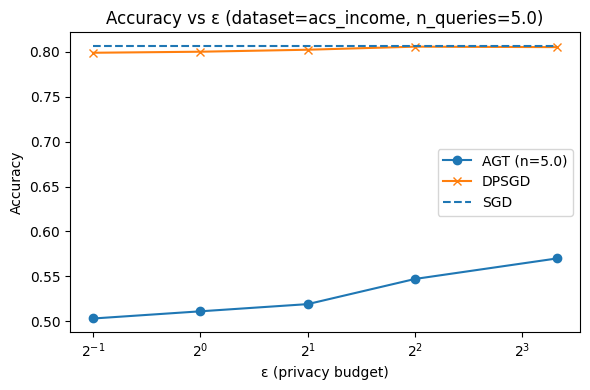

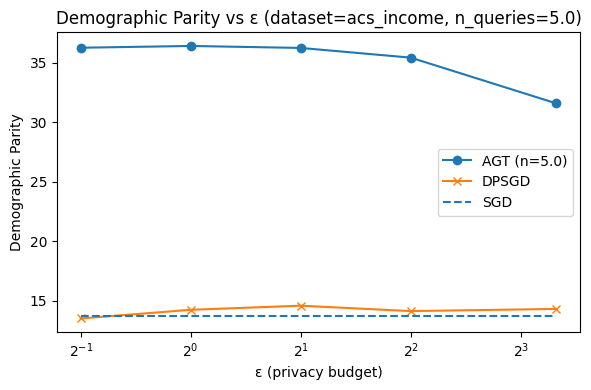

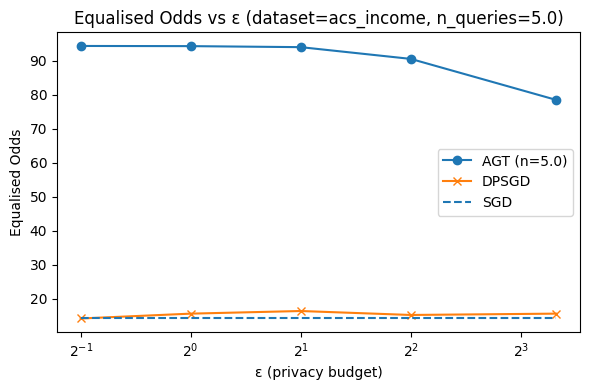

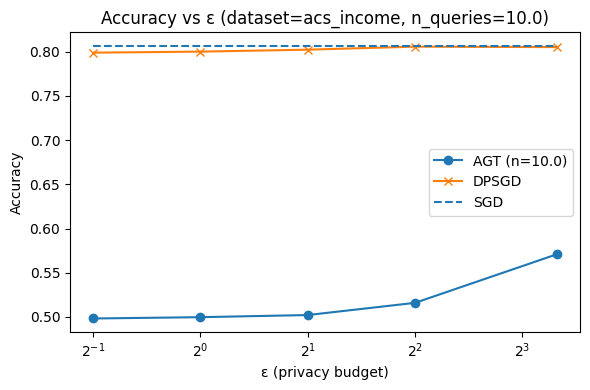

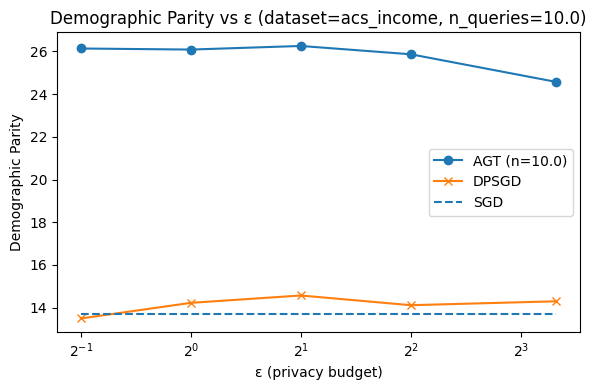

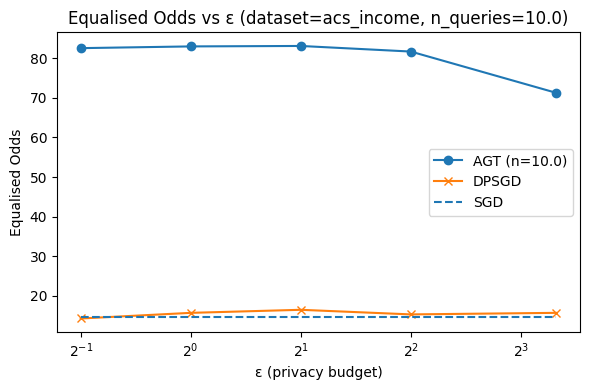

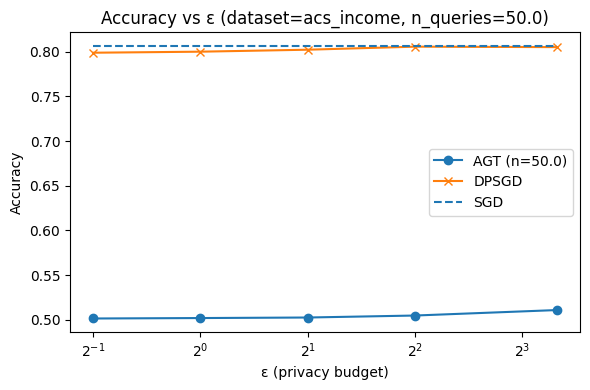

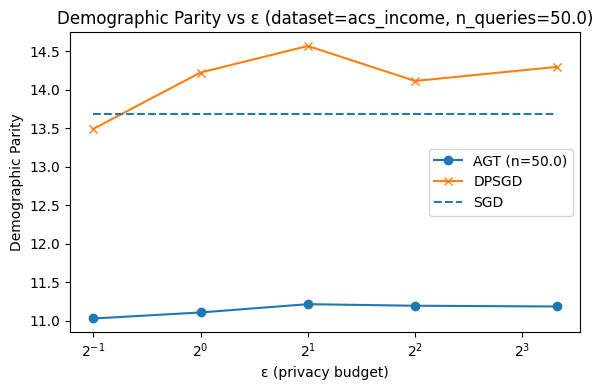

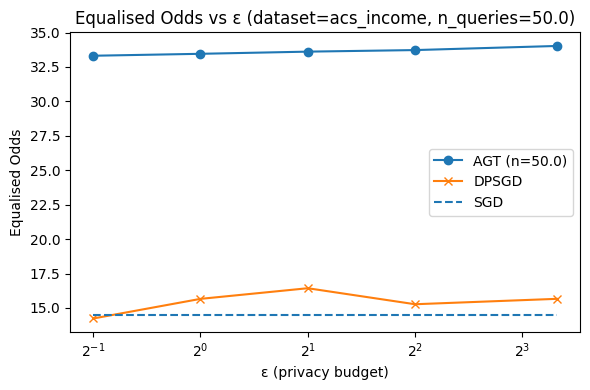

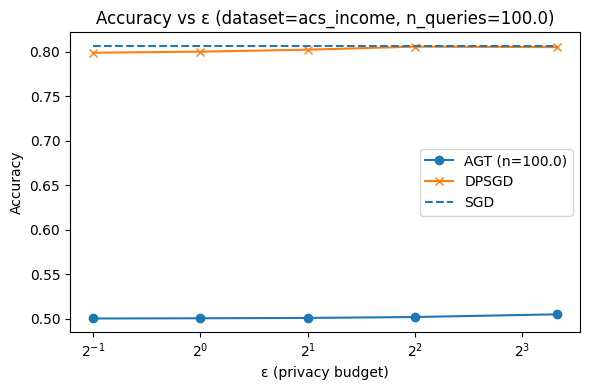

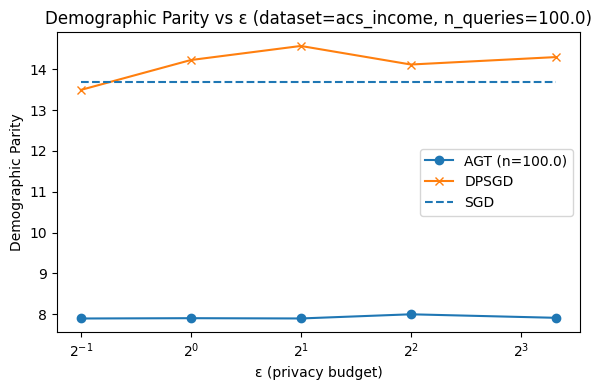

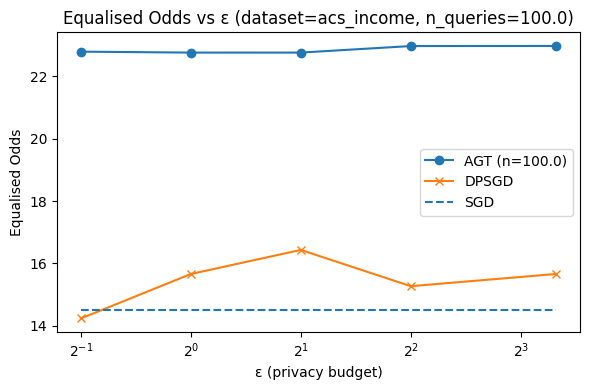

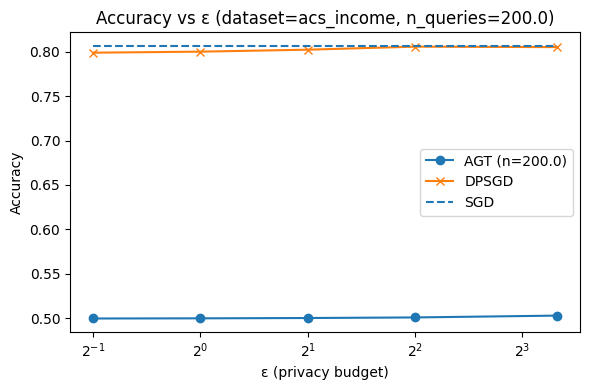

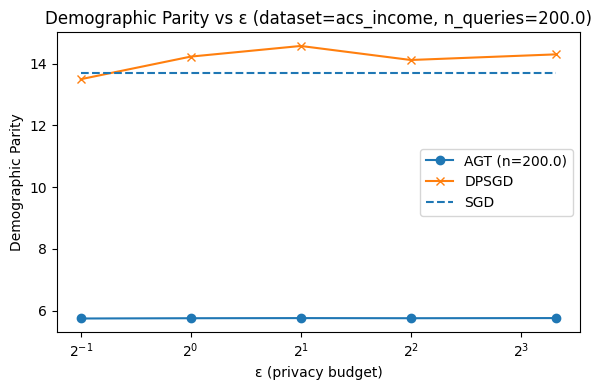

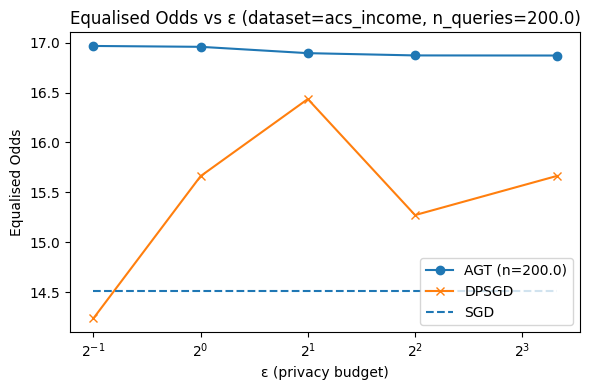

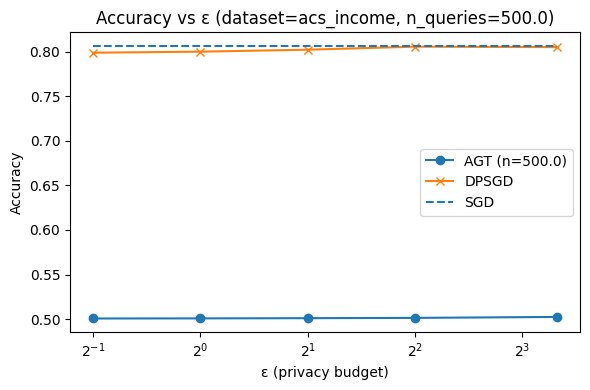

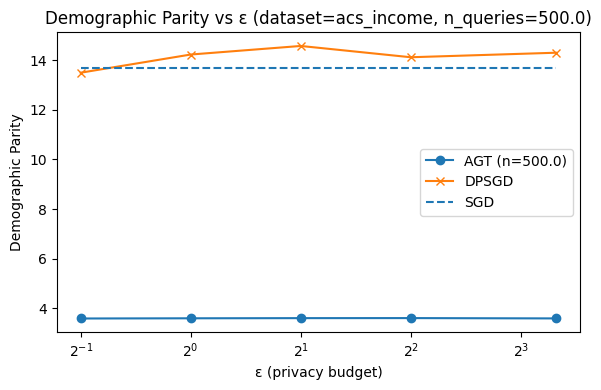

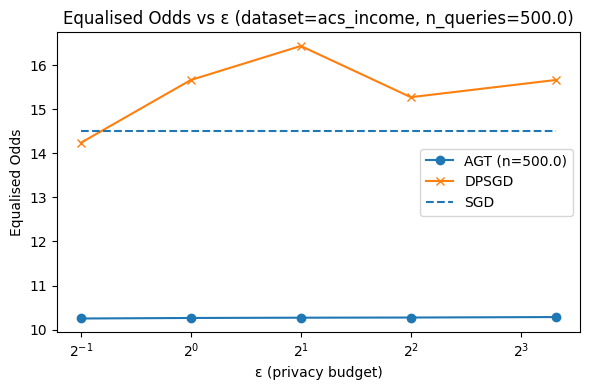

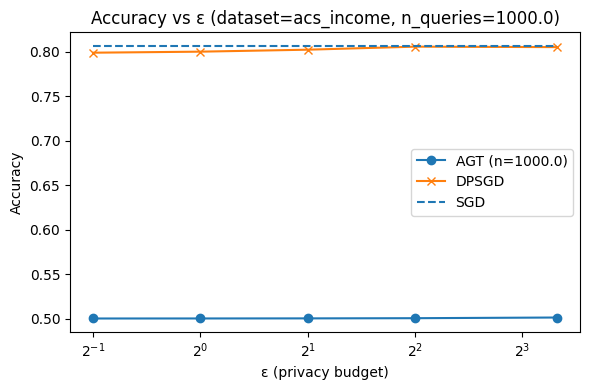

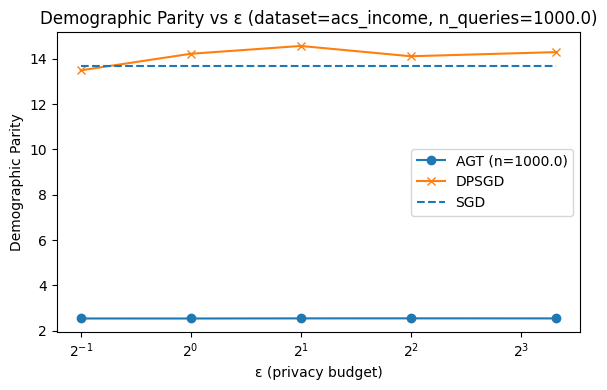

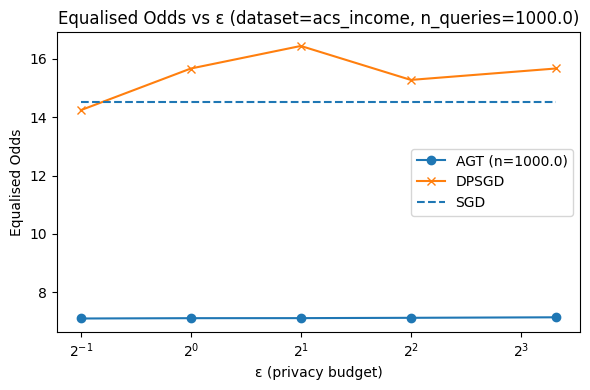

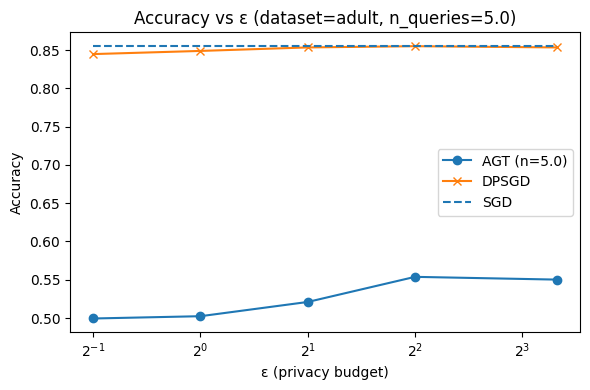

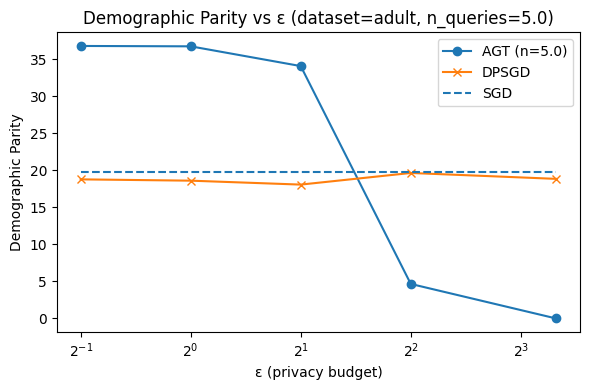

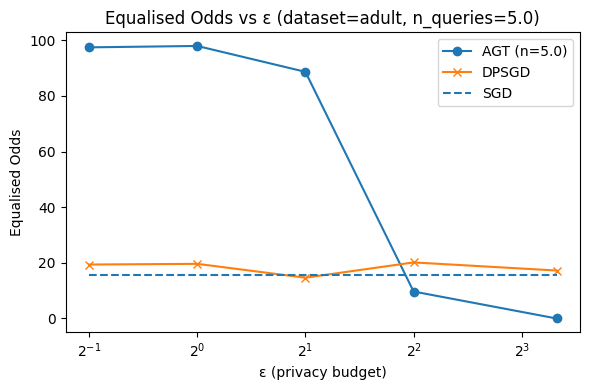

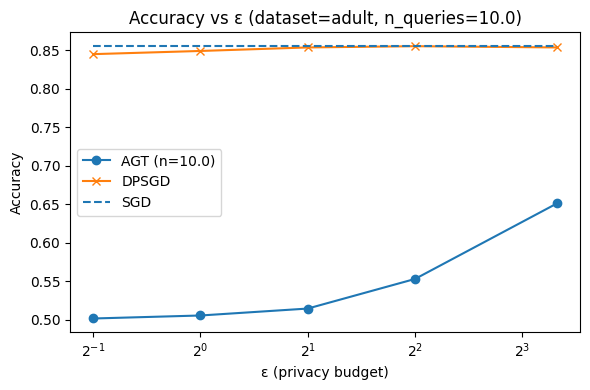

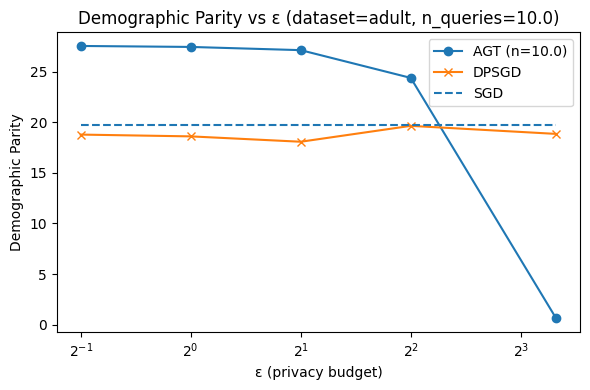

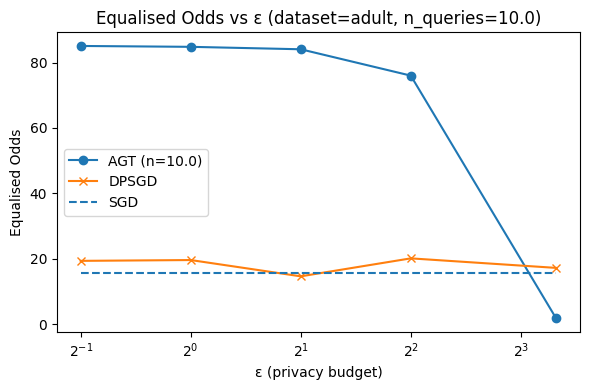

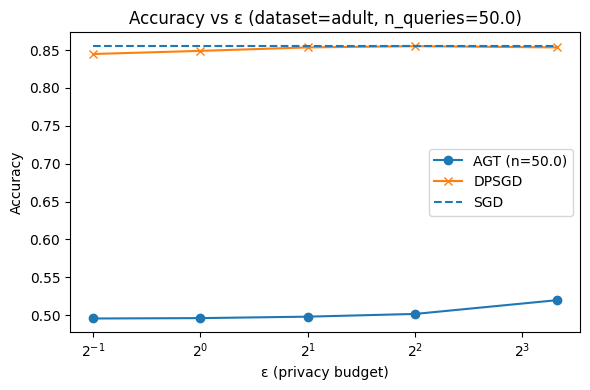

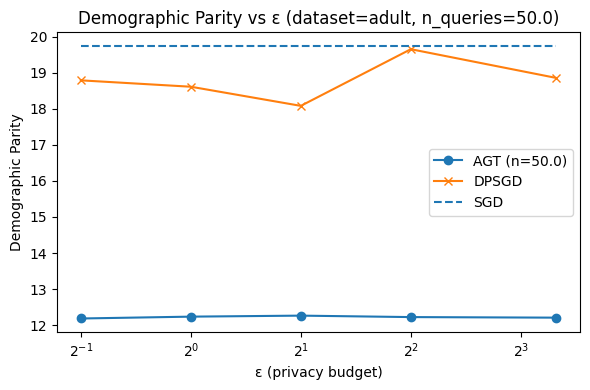

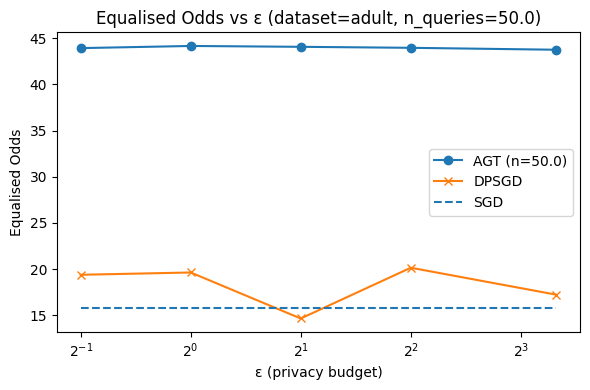

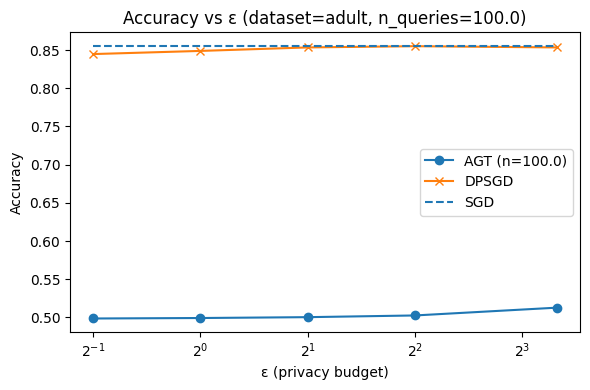

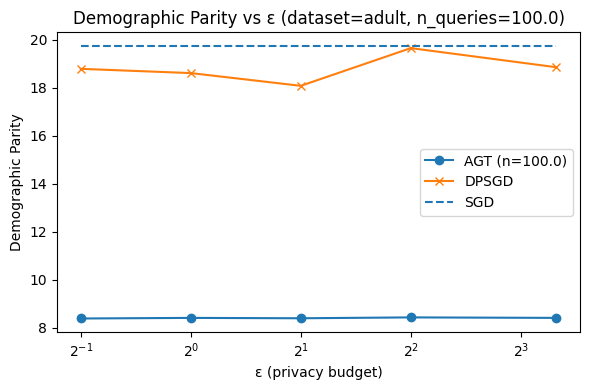

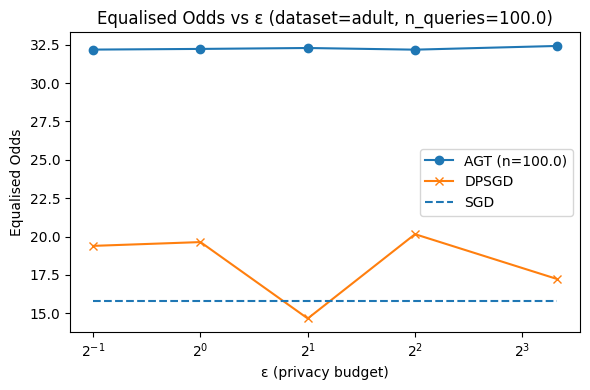

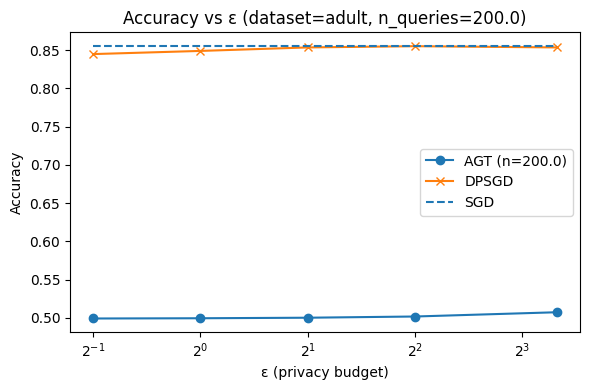

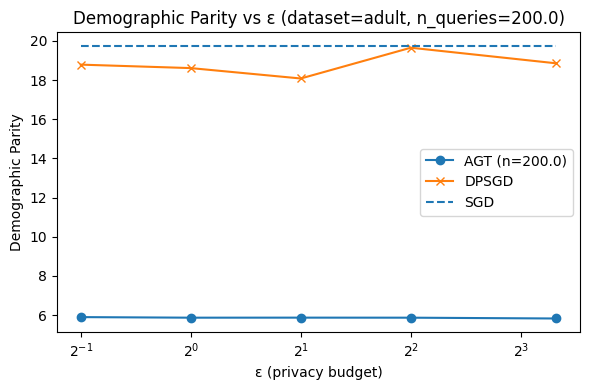

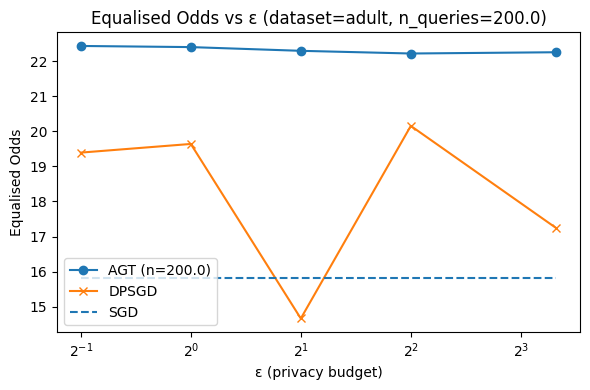

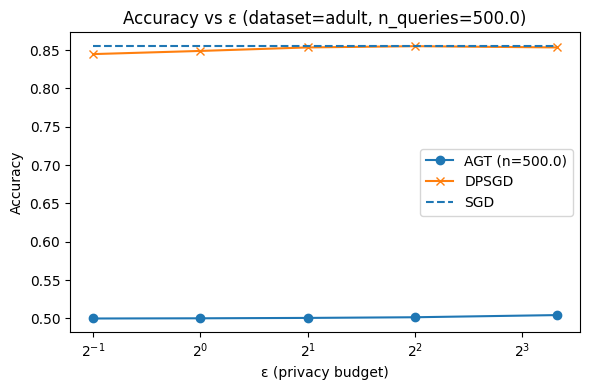

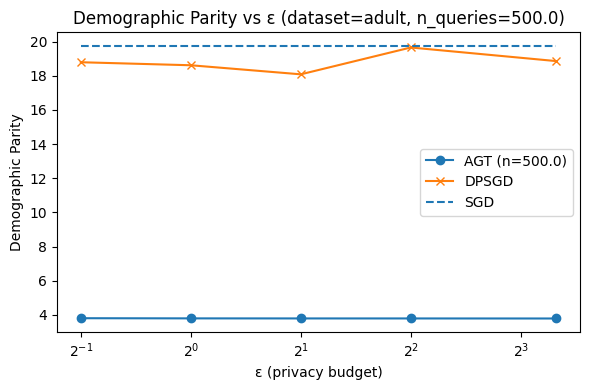

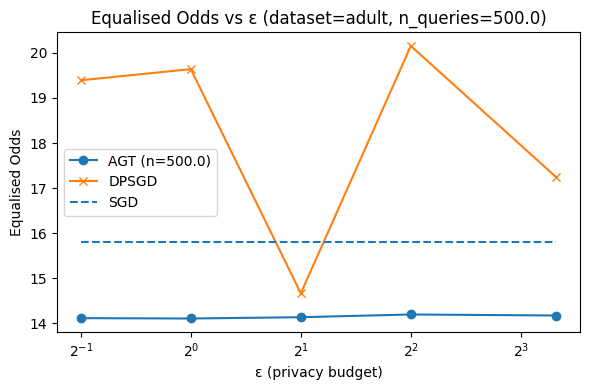

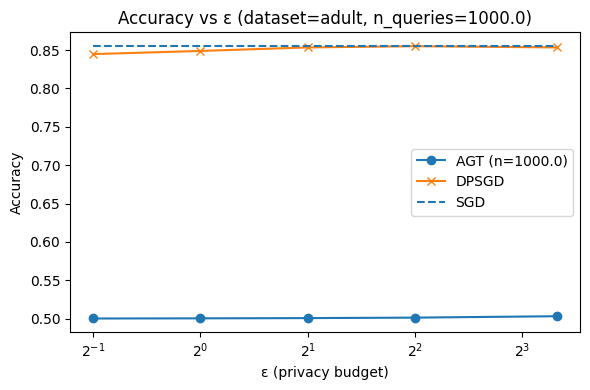

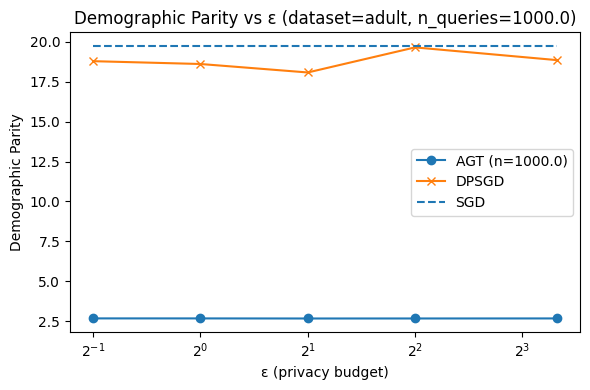

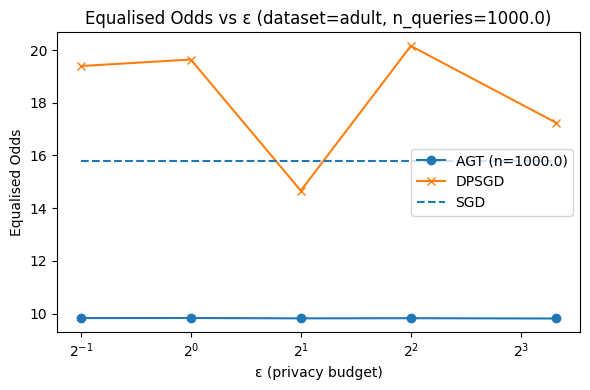

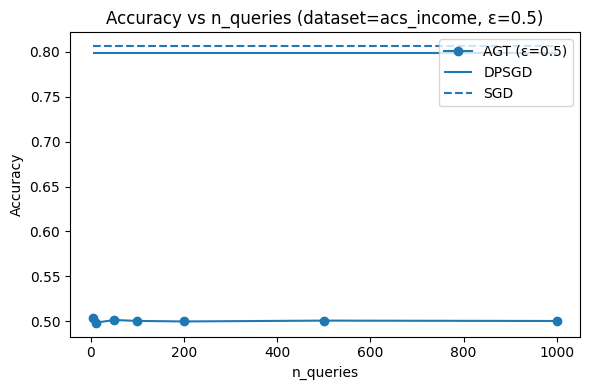

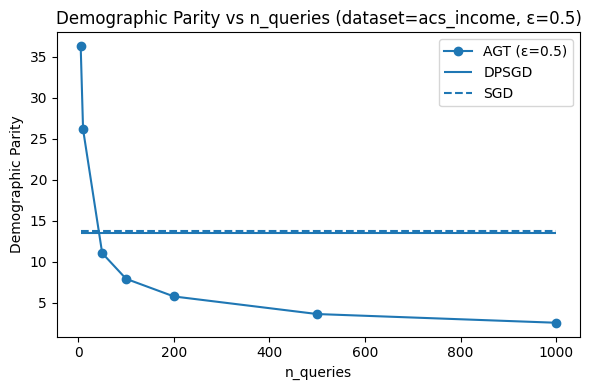

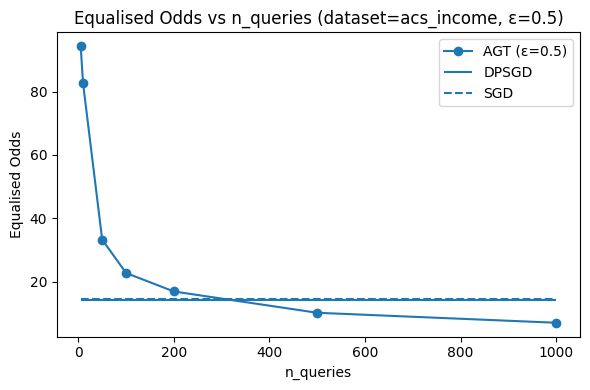

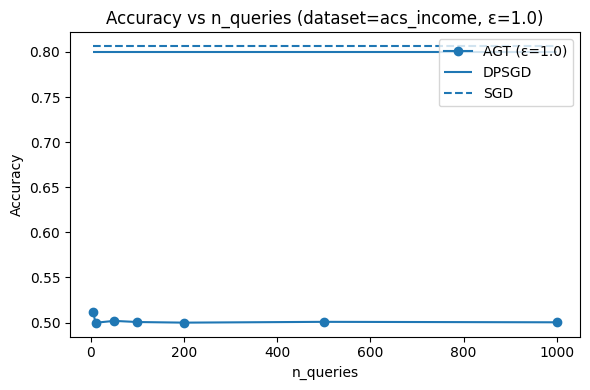

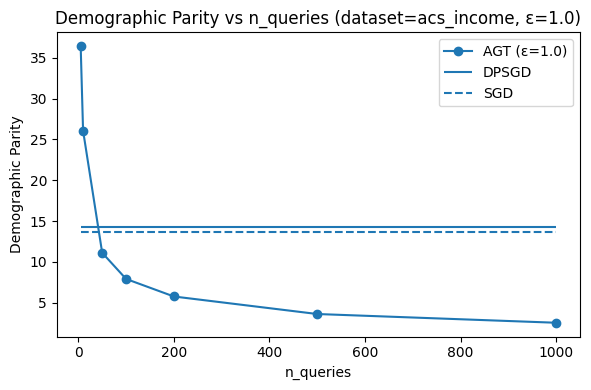

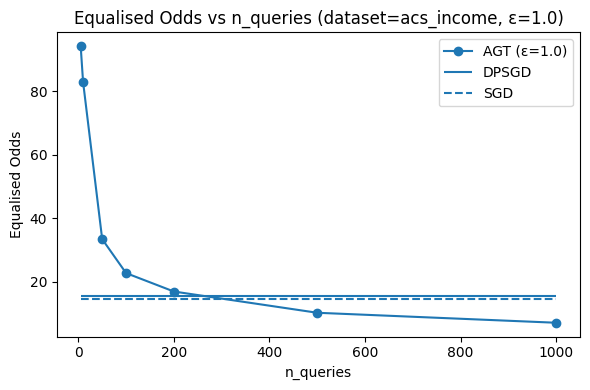

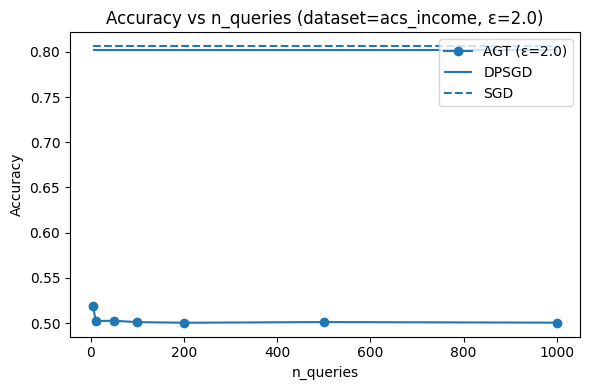

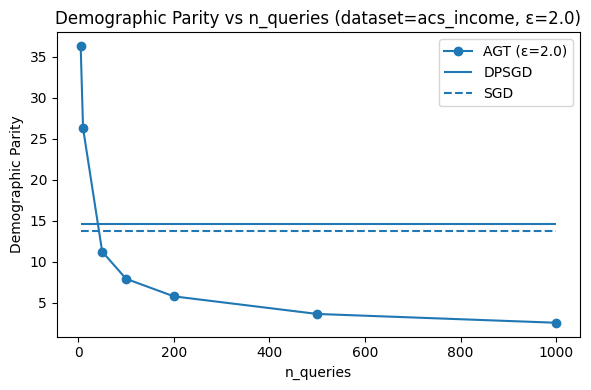

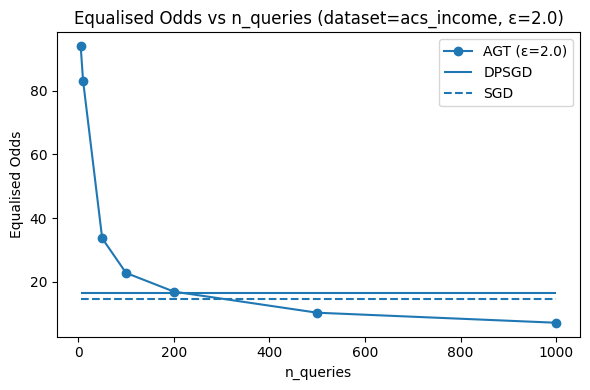

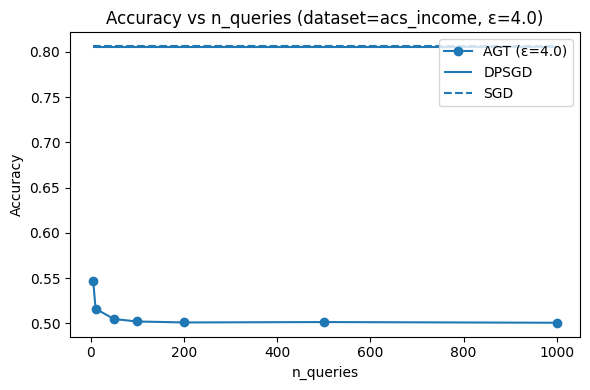

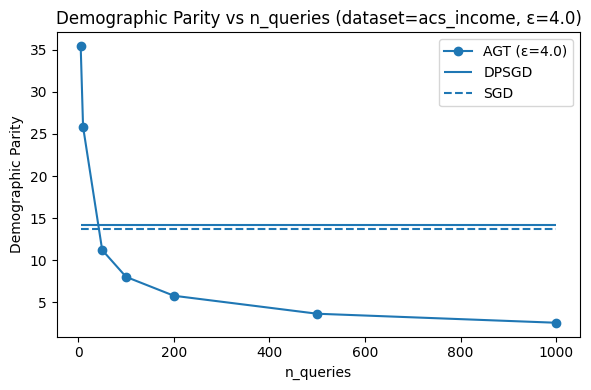

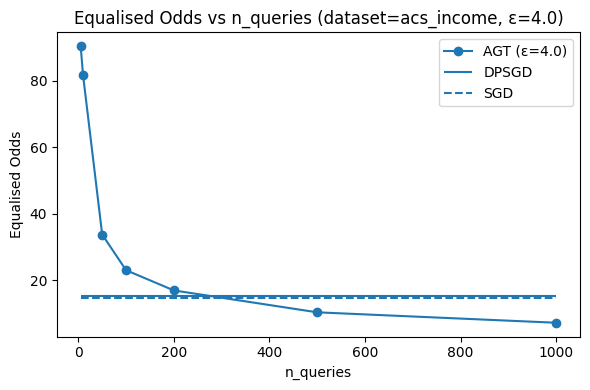

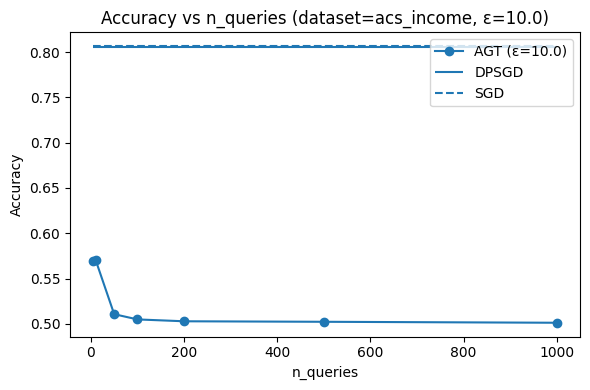

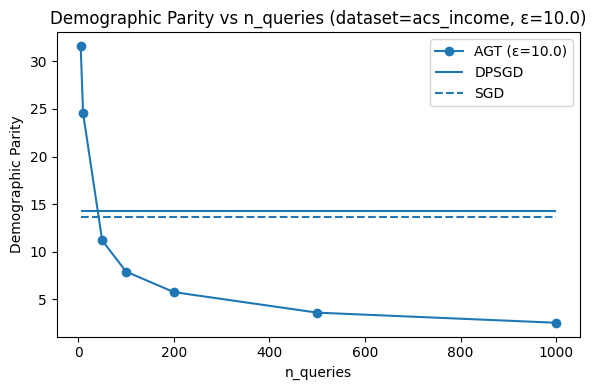

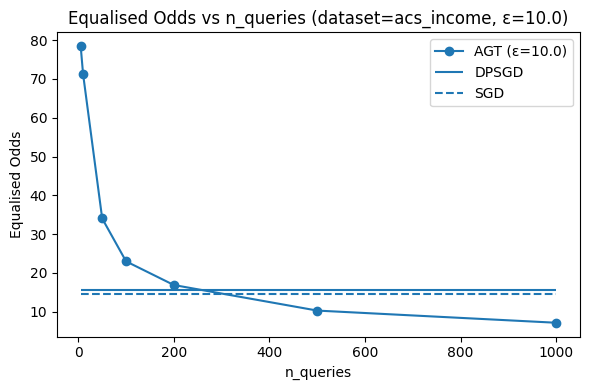

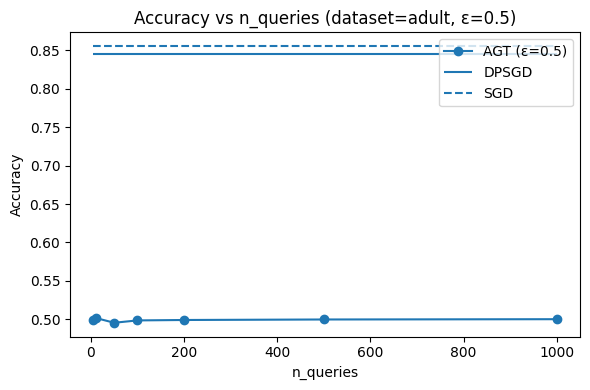

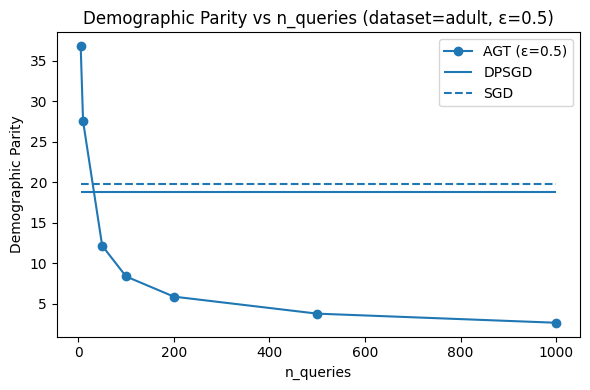

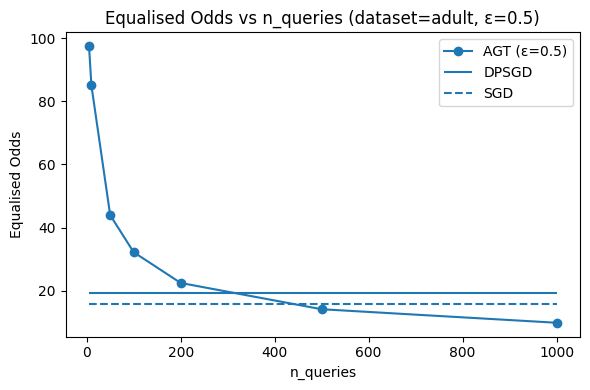

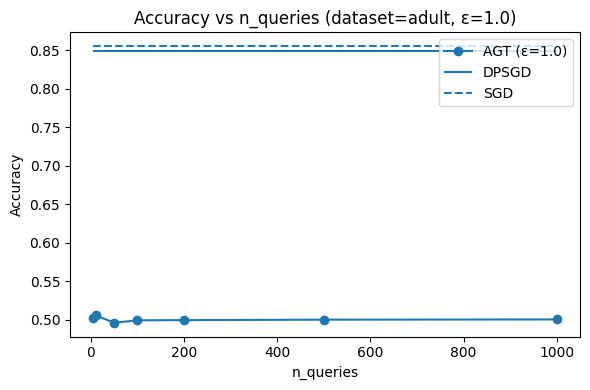

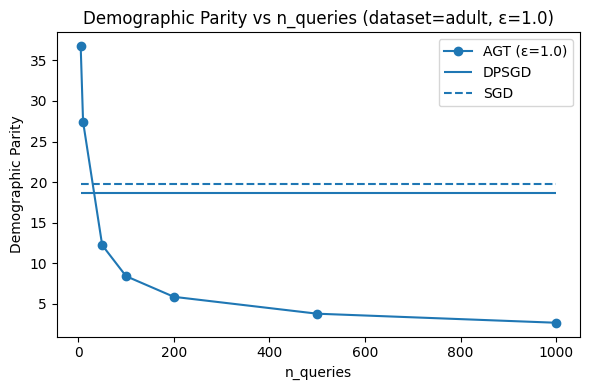

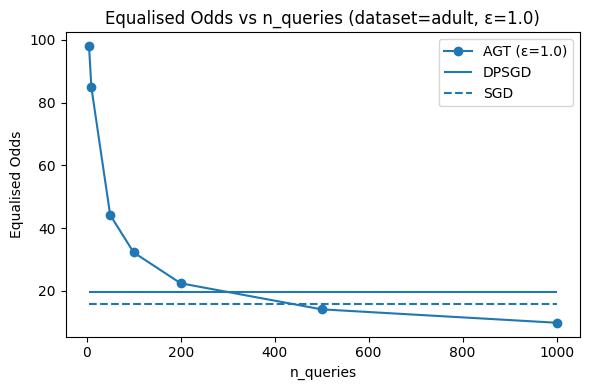

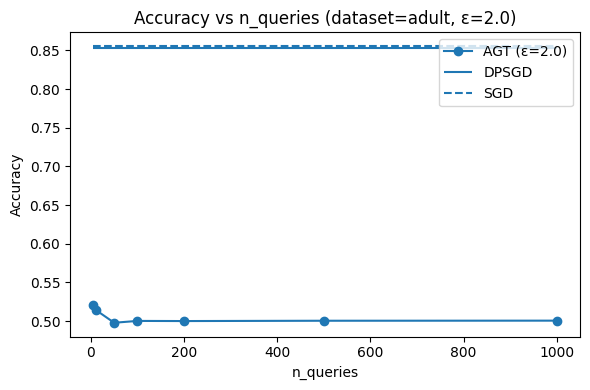

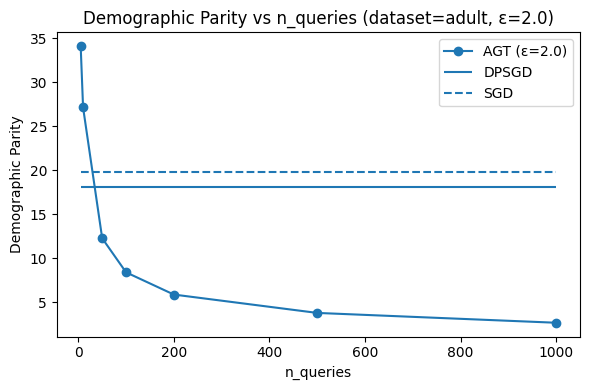

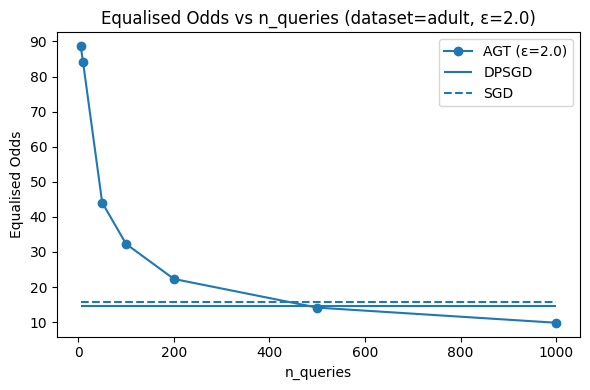

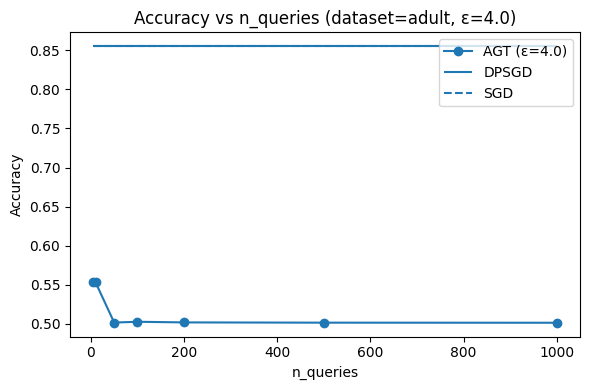

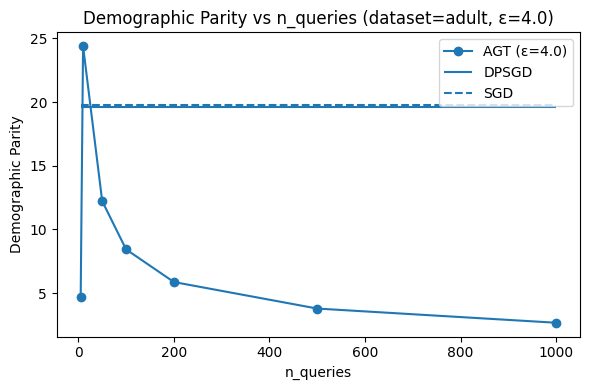

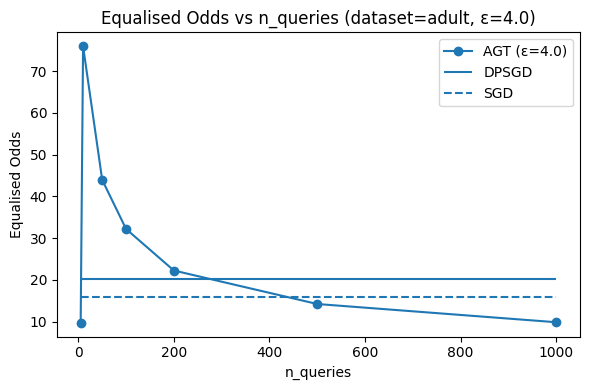

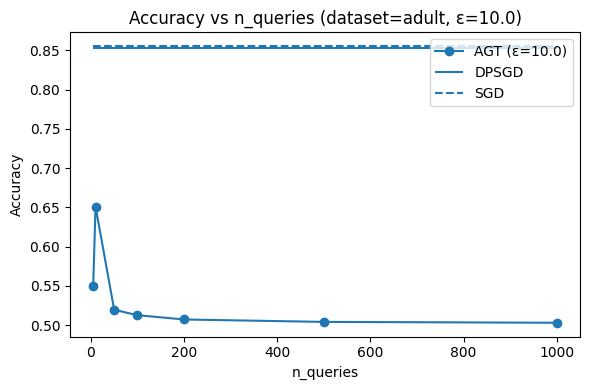

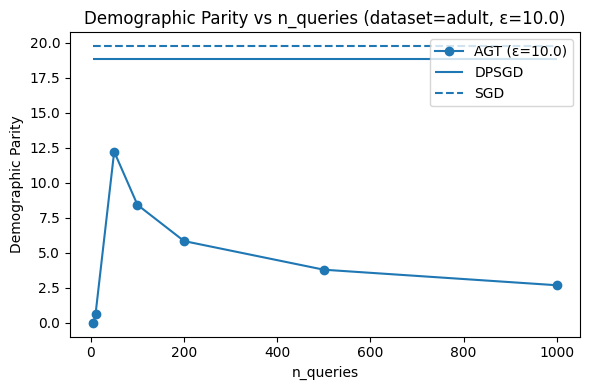

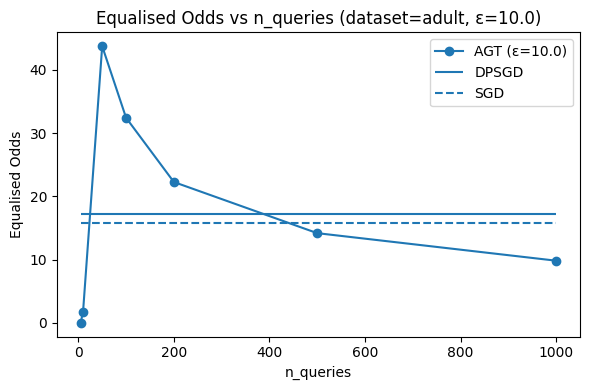

In [ ]:
import matplotlib.pyplot as plt

# --- assume you’ve already run parse_results() and have `df` ---
# df = parse_results('path/to/results')
df_flat  = df.reset_index()
sgd_df    = df_flat[df_flat['technique']=='sgd']
dpsgd_df  = df_flat[df_flat['technique']=='dpsgd']
agt_df    = df_flat[df_flat['technique']=='agt']

# identify your metrics (utility + fairness)
all_metrics       = [c for c in df.columns
                     if not c.startswith('std_')
                     and c not in ['technique','delta','n_queries']]
utility_metric    = 'accuracy'
fairness_metrics  = [m for m in all_metrics if m != utility_metric]

# helper to plot AGT with ±1 std shading
def plot_with_ci(ax, x, mean, std, label, **plt_kwargs):
    ax.plot(x, mean, **plt_kwargs, label=label)
    ax.fill_between(x, mean-std, mean+std, alpha=0.2)

# ──────────────────────────────────────────────────────────────────────────────
# 1) ε vs metrics for AGT at fixed n_queries, with ±1 std, plus DPSGD/SGD baselines
# ──────────────────────────────────────────────────────────────────────────────
fixed_n_list = sorted(agt_df['n_queries'].unique())

for dataset in agt_df['dataset'].unique():
    for n_q in fixed_n_list:
        sub_agt = agt_df[
            (agt_df['dataset']==dataset) &
            (agt_df['n_queries']==n_q)
        ].sort_values('epsilon')
        if sub_agt.empty:
            continue

        base_sgd    = float(sgd_df[sgd_df['dataset']==dataset][utility_metric].iloc[0])
        base_dpsgd  = dpsgd_df[dpsgd_df['dataset']==dataset]

        # accuracy vs ε
        fig, ax = plt.subplots()
        plot_with_ci(
            ax,
            sub_agt['epsilon'],
            sub_agt[utility_metric],
            sub_agt[f'std_{utility_metric}'],
            label=f'AGT (n={n_q})',
            marker='o',
            linestyle='-'
        )
        ax.plot(
            base_dpsgd['epsilon'],
            base_dpsgd[utility_metric],
            'x-',
            label='DPSGD'
        )
        ax.hlines(
            base_sgd,
            xmin=sub_agt['epsilon'].min(),
            xmax=sub_agt['epsilon'].max(),
            linestyles='--',
            label='SGD'
        )
        ax.set_xscale('log', base=2)
        ax.set_xlabel('ε')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'Accuracy vs ε (dataset={dataset}, n_queries={n_q})')
        ax.legend()
        plt.tight_layout()
        plt.show()

        # fairness vs ε
        for metric in fairness_metrics:
            base_sgd_val = float(sgd_df[sgd_df['dataset']==dataset][metric].iloc[0])
            fig, ax = plt.subplots()
            plot_with_ci(
                ax,
                sub_agt['epsilon'],
                sub_agt[metric],
                sub_agt[f'std_{metric}'],
                label=f'AGT (n={n_q})',
                marker='o',
                linestyle='-'
            )
            ax.plot(
                base_dpsgd['epsilon'],
                base_dpsgd[metric],
                'x-',
                label='DPSGD'
            )
            ax.hlines(
                base_sgd_val,
                xmin=sub_agt['epsilon'].min(),
                xmax=sub_agt['epsilon'].max(),
                linestyles='--',
                label='SGD'
            )
            ax.set_xscale('log', base=2)
            ax.set_xlabel('ε')
            ax.set_ylabel(metric.replace('_',' ').title())
            ax.set_title(f'{metric.replace("_"," ").title()} vs ε (dataset={dataset}, n_queries={n_q})')
            ax.legend()
            plt.tight_layout()
            plt.show()


# ──────────────────────────────────────────────────────────────────────────────
# 2) n_queries vs metrics for AGT at fixed ε, with ±1 std, plus DPSGD/SGD baselines
# ──────────────────────────────────────────────────────────────────────────────
fixed_eps_list = sorted(agt_df['epsilon'].unique())

for dataset in agt_df['dataset'].unique():
    for eps in fixed_eps_list:
        sub_agt = agt_df[
            (agt_df['dataset']==dataset) &
            (agt_df['epsilon']==eps)
        ].sort_values('n_queries')
        if sub_agt.empty:
            continue

        base_sgd    = float(sgd_df[sgd_df['dataset']==dataset][utility_metric].iloc[0])
        # find DPSGD at exactly this eps
        base_dpsgd_val = float(
            dpsgd_df[
                (dpsgd_df['dataset']==dataset) &
                (dpsgd_df['epsilon']==eps)
            ][utility_metric].iloc[0]
        )

        # accuracy vs n_queries
        fig, ax = plt.subplots()
        plot_with_ci(
            ax,
            sub_agt['n_queries'],
            sub_agt[utility_metric],
            sub_agt[f'std_{utility_metric}'],
            label=f'AGT (ε={eps})',
            marker='o',
            linestyle='-'
        )
        ax.hlines(
            base_dpsgd_val,
            xmin=sub_agt['n_queries'].min(),
            xmax=sub_agt['n_queries'].max(),
            linestyles='-',
            label='DPSGD'
        )
        ax.hlines(
            base_sgd,
            xmin=sub_agt['n_queries'].min(),
            xmax=sub_agt['n_queries'].max(),
            linestyles='--',
            label='SGD'
        )
        ax.set_xlabel('n_queries')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'Accuracy vs n_queries (dataset={dataset}, ε={eps})')
        ax.legend()
        plt.tight_layout()
        plt.show()

        # fairness vs n_queries
        for metric in fairness_metrics:
            base_dpsgd_met = float(
                dpsgd_df[
                    (dpsgd_df['dataset']==dataset]) &
                    (dpsgd_df['epsilon']==eps)
                ][metric].iloc[0]
            )
            base_sgd_met   = float(sgd_df[sgd_df['dataset']==dataset][metric].iloc[0])

            fig, ax = plt.subplots()
            plot_with_ci(
                ax,
                sub_agt['n_queries'],
                sub_agt[metric],
                sub_agt[f'std_{metric}'],
                label=f'AGT (ε={eps})',
                marker='o',
                linestyle='-'
            )
            ax.hlines(
                base_dpsgd_met,
                xmin=sub_agt['n_queries'].min(),
                xmax=sub_agt['n_queries'].max(),
                linestyles='-',
                label='DPSGD'
            )
            ax.hlines(
                base_sgd_met,
                xmin=sub_agt['n_queries'].min(),
                xmax=sub_agt['n_queries'].max(),
                linestyles='--',
                label='SGD'
            )
            ax.set_xlabel('n_queries')
            ax.set_ylabel(metric.replace('_',' ').title())
            ax.set_title(f'{metric.replace("_"," ").title()} vs n_queries (dataset={dataset}, ε={eps})')
            ax.legend()
            plt.tight_layout()
            plt.show()